# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie

In [3]:
%matplotlib notebook
import math
import random
from sortedcontainers import SortedSet

### Tolerancje przyjmuję na 10^-12

In [4]:
TOLERANCE = 1e-12
TOLERANCE_DECIMALS = 12

In [5]:
def plot_to_lines(plot):
    return [line for line in (lines.lines for lines in plot.get_added_lines())][0] 

### Losowe odcinki

In [6]:
def get_x(lowerLeft, upperRight):
    return round(random.uniform(lowerLeft[0], upperRight[0]), TOLERANCE_DECIMALS)
def get_y(lowerLeft, upperRight):
    return round(random.uniform(lowerLeft[1], upperRight[1]), TOLERANCE_DECIMALS)

#n - number of lines to create
#lowerLeft - tuple representing lower left corner of our range rectanglge
#upperRight - tuple representing upper right corner of our range rectanglge
def random_lines(n, lowerLeft, upperRight):
    points = set()
    lines = []

    while len(lines) < n:
        x1 = get_x(lowerLeft, upperRight)
        y1 = get_y(lowerLeft, upperRight)
        x2 = get_x(lowerLeft, upperRight)
        y2 = get_y(lowerLeft, upperRight)
        
        if x1 == x2 or len({x1,x2,y1,y2} & points):
            continue
            
        lines.append([(x1,y1), (x2,y2)])
        points.update([x1,x2,y1,y2])
       
    return lines

### przykład działania

<IPython.core.display.Javascript object>


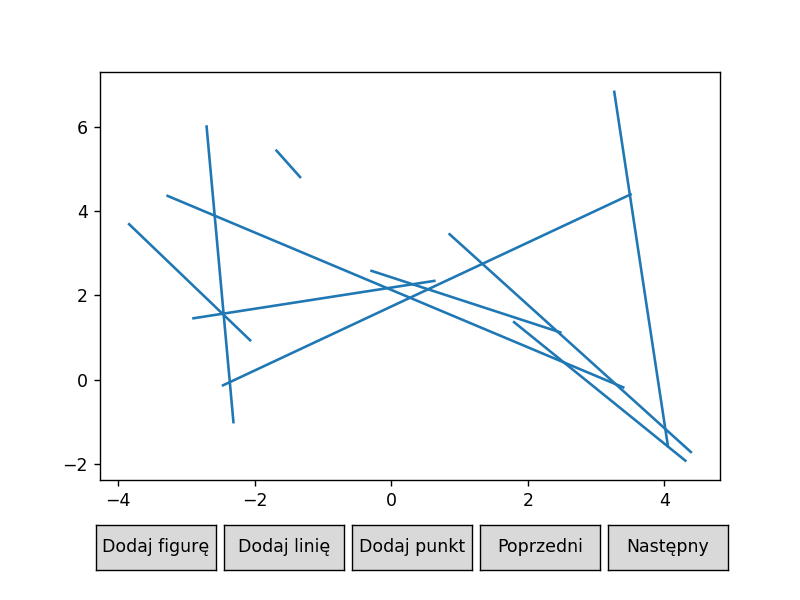

In [7]:
l = random_lines(10, (-4, -3), (5, 7))
plot = Plot([Scene(lines=[LinesCollection(l)])])
plot.draw()

### Zapis odcinków do pliku

In [8]:
def save_lines_to_file(lines, name):
    with open(name, 'w') as file:
       file.write(js.dumps(lines))

In [9]:
def save_plot_to_file(plot, name):
    with open(name, 'w') as file:
       file.write(js.dumps(plot_to_lines(plot)))

### Czytanie odcinków z pliku

In [10]:
def read_lines_from_file(name):
    with open(name, 'r') as file:
        lines = js.loads(file.read())
    return lines

### WŁASNE RYSOWANIE

<IPython.core.display.Javascript object>


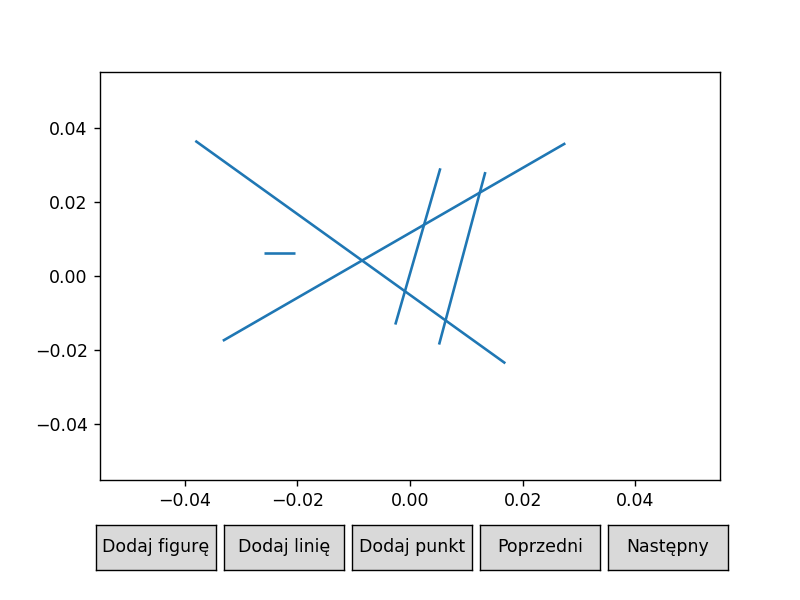

In [10]:
# plot = Plot(points = [PointsCollection([])])
plot1 = Plot()
plot1.draw()

In [11]:
l = plot_to_lines(plot1)

<IPython.core.display.Javascript object>


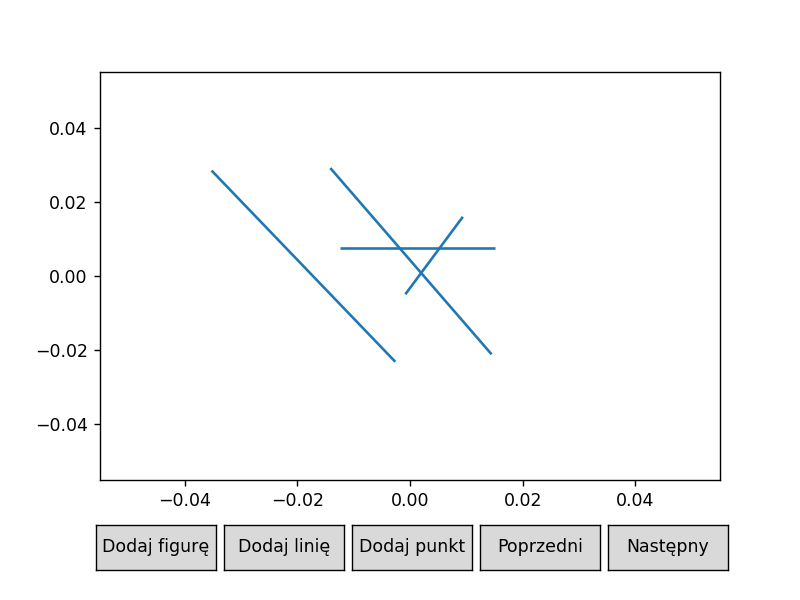

In [20]:
plot1 = Plot()
plot1.draw()

In [21]:
lx = plot_to_lines(plot1)

### Klasa PUNKT

In [11]:
# x -> point x-ax
# y -> point y-ax
# s -> line 1. index
# t -> line 2. index
# if two indexes are equal this point is end of one segment, otherwise it's one of the intersection points
# __gt__ makes it that sorted set pop returns point with lowest x value
class Point:
    def __init__(self, x, y, s, t):
        self.x = x
        self.y = y
        self.s = s
        self.t = t
       
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __gt__(self, other):
        return self.x > other.x
    
    def __hash__(self):
        return hash((self.x, self.y))

### Klasa LINIA

In [12]:
class Line:
    def __init__(self, A, B):
        if A.x > B.x:
            A,B = B,A
        self.A = A
        self.B = B
        self.a = (self.A.y - self.B.y) / (self.A.x - self.B.x)
        self.b = self.A.y - self.a * self.A.x
        self.x = self.A.x
        
    def update_x(x):
        Line.x = x
        
    def __eq__(self, other):
        return self.A == other.A and self.B == other.B
    
    def __gt__(self, other):
        return self.a * Line.x + self.b > other.a * Line.x + other.b
    
    def __hash__(self):
        return hash((self.A, self.B))

### Funkcje pomocnicze

In [13]:
def get_lines_and_points(lines_raw):
    lines = []
    points = []
    for i, line in enumerate(lines_raw):
        A = Point(line[0][0], line[0][1], i, i)
        B = Point(line[1][0], line[1][1], i, i)
        points.extend([A,B])
        lines.append(Line(A, B))

    return lines, points

In [14]:
def on_segment(a,b,c):
    return min(a.x, b.x) <= c.x <= max(a.x, b.x) and min(a.y, b.y) <= c.y <= max(a.y, b.y)

In [15]:
def det_3x3(a):
    return a[0][0] * (a[1][1] * a[2][2] - a[2][1] * a[1][2])\
           -a[1][0] * (a[0][1] * a[2][2] - a[2][1] * a[0][2])\
           +a[2][0] * (a[0][1] * a[1][2] - a[1][1] * a[0][2])
def det(a,b,c):
    matrix = np.array([[a.x, a.y, 1], [b.x, b.y, 1], [c.x, c.y, 1]])
    return det_3x3(matrix)
def orient(a, b, c):
    d = det(a, b, c)
    if d > TOLERANCE:
        return 1
    elif d < - TOLERANCE:
        return -1
    else:
        return 0

In [16]:
def intersect(l1, l2):
    p1 = l1.A
    p2 = l1.B
    p3 = l2.A
    p4 = l2.B
    o1 = orient(p1, p2, p3)
    o2 = orient(p1, p2, p4)
    o3 = orient(p3, p4, p1)
    o4 = orient(p3, p4, p2)
    
    if o1 != o2 and o3 != o4:
        return True
    if o1 == 0 and on_segment(p1,p2,p3):
        return True
    if o2 == 0 and on_segment(p1,p2,p4):
        return True
    if o3 == 0 and on_segment(p3,p4,p1):
        return True
    return o4 == 0 and on_segment(p3,p4,p2)

### Funkcja sprawdza czy jest chociaż jeden punkt przecięcia

In [17]:
def any_intersections(lines_raw):
    
    def get_drawing_bounds():
        bounds = 0
        for line in lines_raw:
            bounds = max(bounds, abs(line[0][1]), abs(line[1][1]))
        return bounds
    
    def line_to_points(line):
        return [(line.A.x, line.A.y),(line.B.x, line.B.y)]
    
    def add_scene():
        current_lines = [line_to_points(line) for line in T]
        scenes.append(Scene([PointsCollection([(p.x, p.y)], color='red')], 
                            [LinesCollection(lines_raw, color='lightblue'), 
                             LinesCollection([sweeper], color='red'), 
                             LinesCollection(current_lines.copy(), color='C0')]))
    
    lines, points = get_lines_and_points(lines_raw)
    BOUNDS = get_drawing_bounds()
    
#   Q as list sorted only once is enough in this case as we are not adding points to Q anywhere later
    Q = sorted([point for point in points])
    T = SortedSet()

    scenes = []
    Line.update_x(Q[0].x)

    while len(Q) > 0:
        p = Q.pop(0) 
        line = lines[p.s]
    
        sweeper = [(p.x, -BOUNDS), (p.x, BOUNDS)]
        add_scene()
        
#       1st case -> p is left end of segment
        if p == line.A:
#         updating x value so that lines know where sweeper is at the moment
            Line.update_x(p.x)
            T.add(line)
            add_scene()
            
            i = T.index(line)
            if (i-1 >= 0 and intersect(T[i-1], T[i])) or (i+1 < len(T) and intersect(T[i+1], T[i])):
                return True, scenes
#       2nd case -> p is right end of segment
        else:
            i = T.index(line)
            if i-1 >= 0 and i+1 < len(T) and intersect(T[i-1], T[i+1]):
                add_scene()
                return True, scenes
            
            T.remove(line)
            add_scene()
       
    return False, scenes

In [18]:
def intersection_point(l1,l2):
    if not intersect(l1,l2):
        return None
    x = (l2.b - l1.b)/(l1.a - l2.a)
    return Point(x, l1.a*x + l1.b, l1.A.s, l2.A.s)

In [19]:
def find_intersections(lines_raw):
    
    def get_drawing_bounds():
        bounds = 0
        for line in lines_raw:
            bounds = max(bounds, abs(line[0][1]), abs(line[1][1]))
        return bounds
    
    def add_scene():
        current_lines = [[(l.A.x, l.A.y),(l.B.x, l.B.y)] for l in T]
        scenes.append(Scene([PointsCollection(result.copy()), 
                             PointsCollection([(p.x, p.y)], color='red')], 
                            [LinesCollection(lines_raw, color='lightblue'), 
                             LinesCollection([sweeper], color='red'), 
                             LinesCollection(current_lines.copy(), color='C0')]))

    def check_duplicates(l1, l2):
        i = lines.index(l1)
        j = lines.index(l2)
        if i > j:
            i,j = j,i
#         if point's start is i and point's end is j we return true, because these are duplicates
        for point in result_full:
            if (point.s == i and point.t == j):
                return True

        return False
    
    def check_intersect(l1, l2, p):
        if lines[p.s].A != p and check_duplicates(l1, l2):
            return
        
        if l1.A.s > l2.A.s:
            l1, l2 = l2, l1
        
        intersect_point = intersection_point(l1, l2)
        if intersect_point:
            Q.add(intersect_point)
            result.append((intersect_point.x,intersect_point.y))
            result_full.append(intersect_point)
            add_scene()
    
    lines, points = get_lines_and_points(lines_raw)
    BOUNDS = get_drawing_bounds()
    
    Q = SortedSet()
    T = SortedSet()

    for point in points:
        Q.add(point)     

    result = []
    result_full = []
    scenes = []
    Line.update_x(Q[0].x)

    while len(Q) > 0:
        p = Q.pop(0) 
        line1 = lines[p.s]
        line2 = lines[p.t]
    
        sweeper = [(p.x, -BOUNDS), (p.x, BOUNDS)]
        add_scene()
        
#         1st case -> p is left end of segment
        if p == line1.A:
            Line.update_x(p.x)
            T.add(line1) 
            add_scene()
            i = T.index(line1)
            if i-1 >= 0:
                check_intersect(T[i-1], T[i], p)
            if i+1 < len(T):
                check_intersect(T[i+1], T[i], p)
#         2nd case -> p is right end of segment        
        elif p == line1.B:
            i = T.index(line1)
            if i+1 < len(T) and i-1 >= 0:
                check_intersect(T[i+1], T[i-1], p)
            
            T.remove(line1)
            
            add_scene()
#         3rd case -> p is point of intersection       
        else: 
            T.remove(line1)
            T.remove(line2)
            
            Line.update_x(p.x+0.0000000001)

            T.add(line1)
            T.add(line2)
            
            i = T.index(line1)
            j = T.index(line2)
            
            if i > j:
                i, j = j, i
            
            if i-1 >= 0:
                check_intersect(T[i],T[i-1],p)
            if j+1 < len(T):
                check_intersect(T[j],T[j+1],p)
                
            add_scene()
       
    scenes = [Scene([PointsCollection(result.copy())], [LinesCollection(lines_raw)])] + scenes
    return result, result_full, scenes

### Testowanie działania programu

### Zestaw 1

<IPython.core.display.Javascript object>


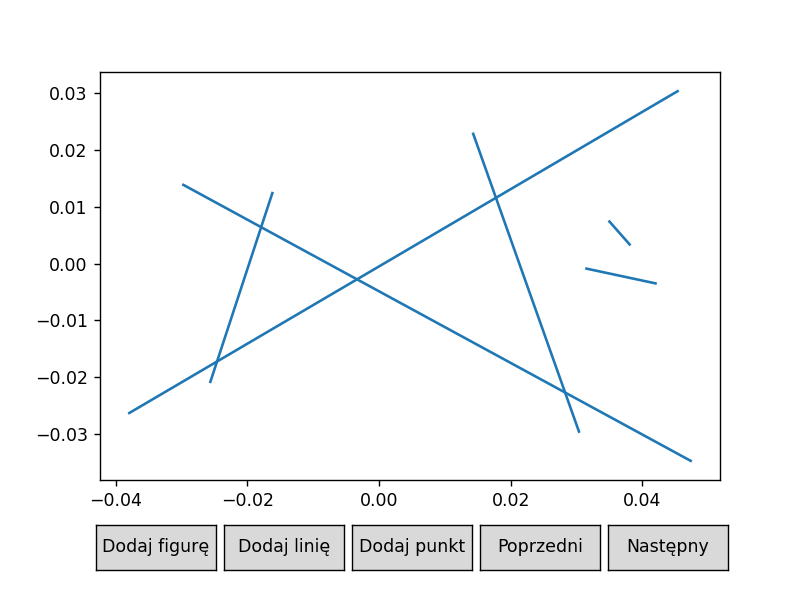

In [20]:
l1 = read_lines_from_file('set1.json')
plot = Plot([Scene(lines=[LinesCollection(l1)])])
plot.draw()

### Sprawdzanie istnienia jednego przecięcia

True


<IPython.core.display.Javascript object>


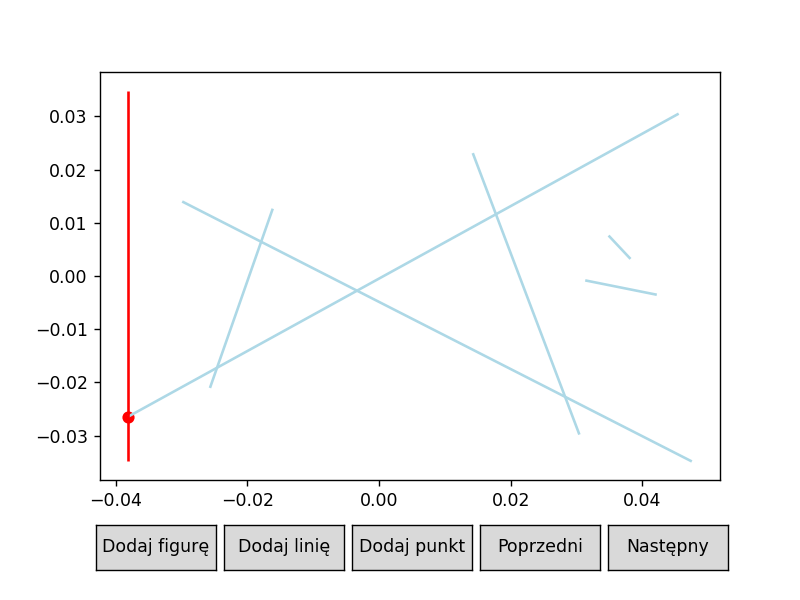

In [21]:
flag, scenes = any_intersections(l1)

plot = Plot(scenes=scenes)
print(flag)
plot.draw()

### Znajdowanie wszystkich przecięć

5


<IPython.core.display.Javascript object>


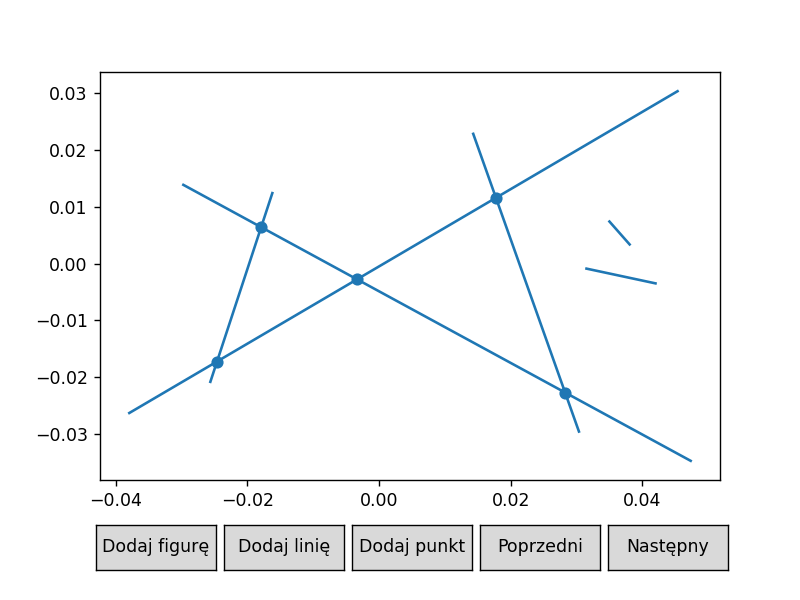

In [22]:
result, result_full, scenes = find_intersections(l1)
plot = Plot(scenes=scenes)
print(len(result))
plot.draw()

### Zestaw 2

<IPython.core.display.Javascript object>


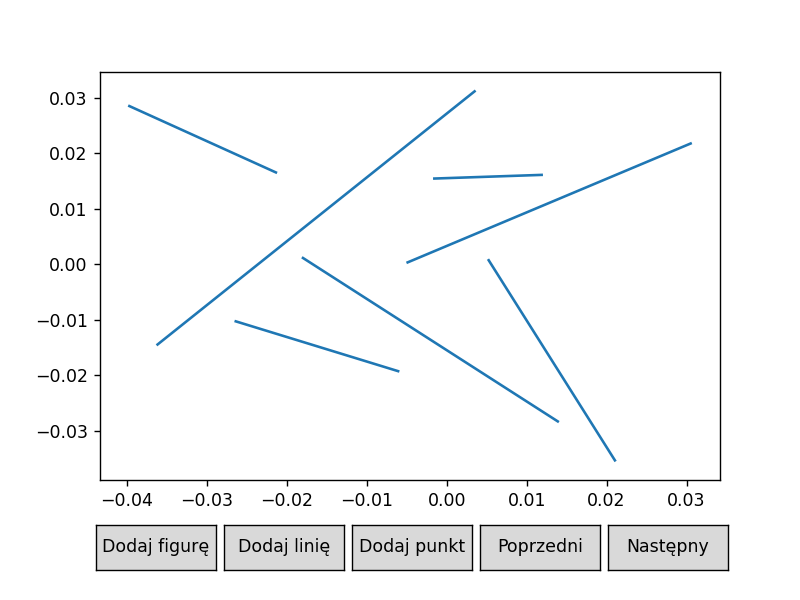

In [23]:
l2 = read_lines_from_file('set2.json')
plot = Plot([Scene(lines=[LinesCollection(l2)])])
plot.draw()

### Sprawdzanie istnienia jednego przecięcia

False


<IPython.core.display.Javascript object>


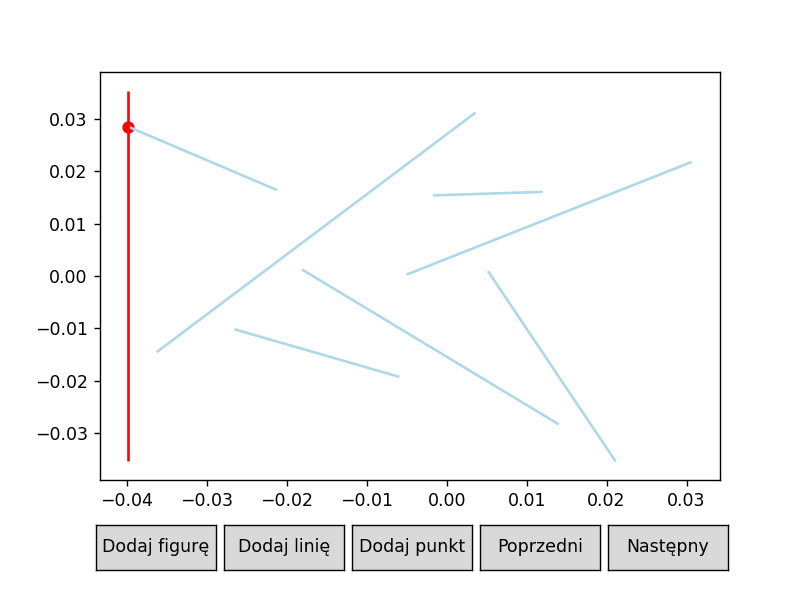

In [24]:
flag, scenes = any_intersections(l2)

plot = Plot(scenes=scenes)
print(flag)
plot.draw()

### Znajdowanie wszystkich przecięć

0


<IPython.core.display.Javascript object>


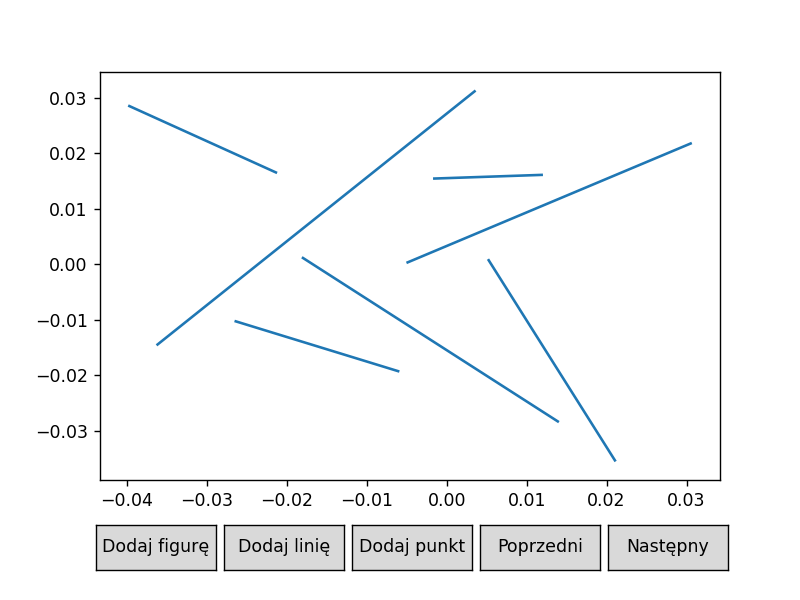

In [25]:
result, result_full, scenes = find_intersections(l2)
plot = Plot(scenes=scenes)
print(len(result))
plot.draw()

### Zestaw 3

<IPython.core.display.Javascript object>


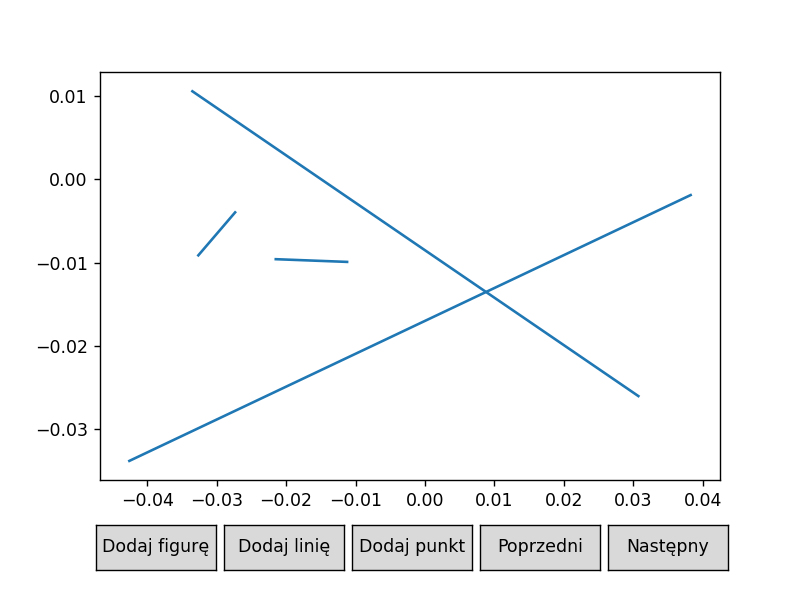

In [26]:
l3 = read_lines_from_file('set3.json')
plot = Plot([Scene(lines=[LinesCollection(l3)])])
plot.draw()

### Sprawdzanie istnienia jednego przecięcia

True


<IPython.core.display.Javascript object>


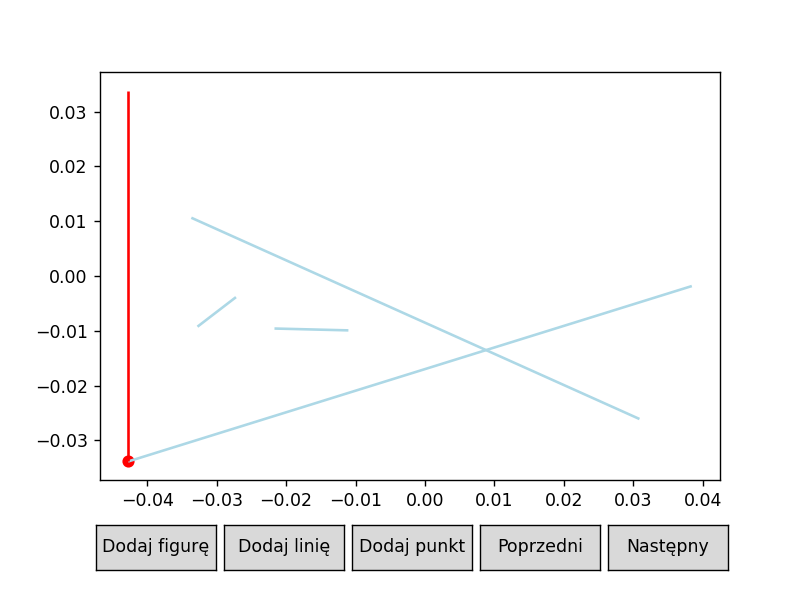

In [27]:
flag, scenes = any_intersections(l3)

plot = Plot(scenes=scenes)
print(flag)
plot.draw()

### Znajdowanie wszystkich przecięć

1


<IPython.core.display.Javascript object>


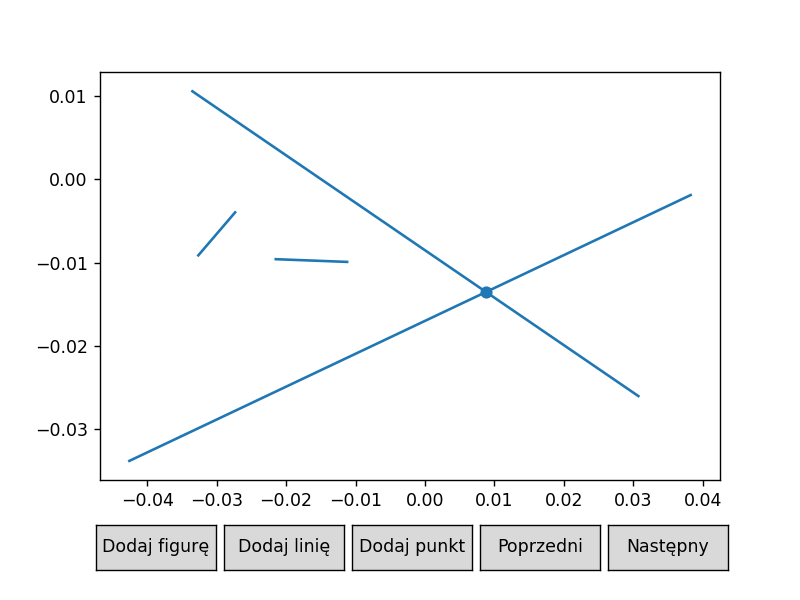

In [28]:
result, result_full, scenes = find_intersections(l3)
plot = Plot(scenes=scenes)
print(len(result))
plot.draw()

### Zestaw 4

<IPython.core.display.Javascript object>


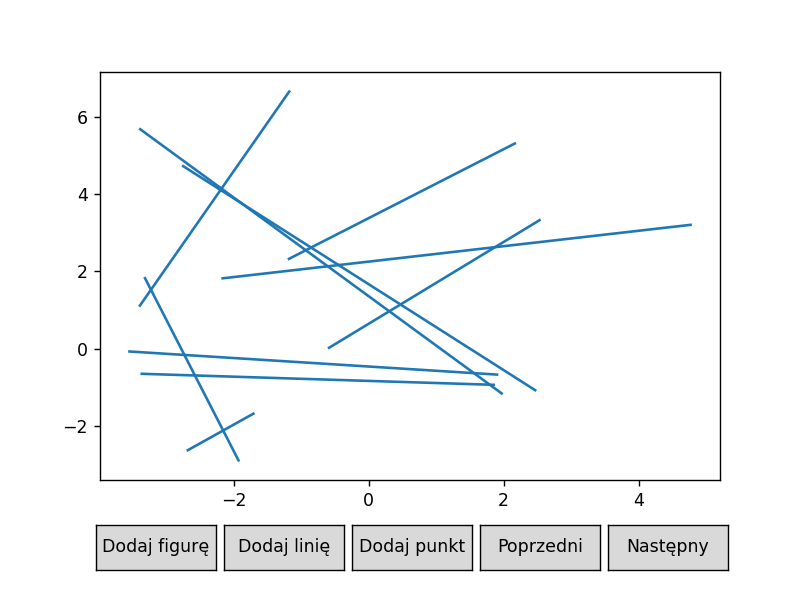

In [29]:
l4 = read_lines_from_file('set4.json')
plot = Plot([Scene(lines=[LinesCollection(l4)])])
plot.draw()

### Sprawdzanie istnienia jednego przecięcia

True


<IPython.core.display.Javascript object>


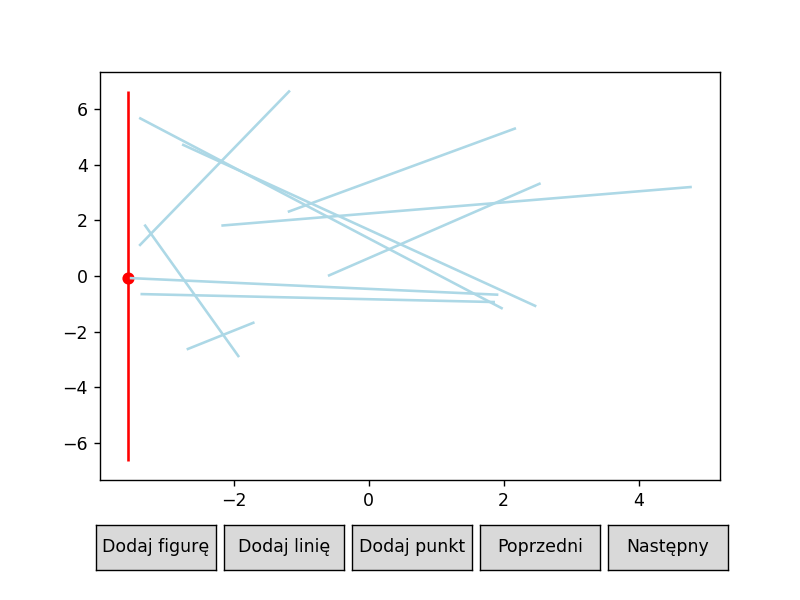

In [30]:
flag, scenes = any_intersections(l4)

plot = Plot(scenes=scenes)
print(flag)
plot.draw()

### Znajdowanie wszystkich przecięć

16


<IPython.core.display.Javascript object>


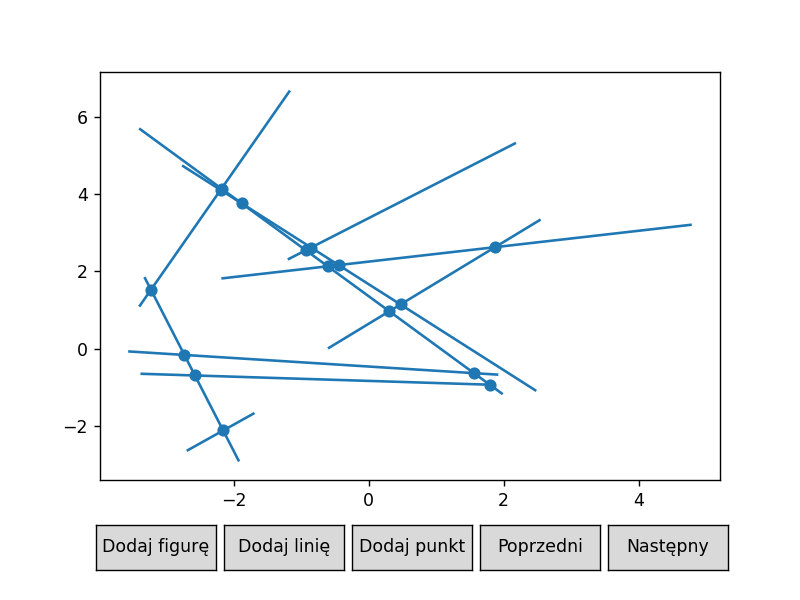

In [31]:
result, result_full, scenes = find_intersections(l4)
plot = Plot(scenes=scenes)
print(len(result))
plot.draw()

True


<IPython.core.display.Javascript object>


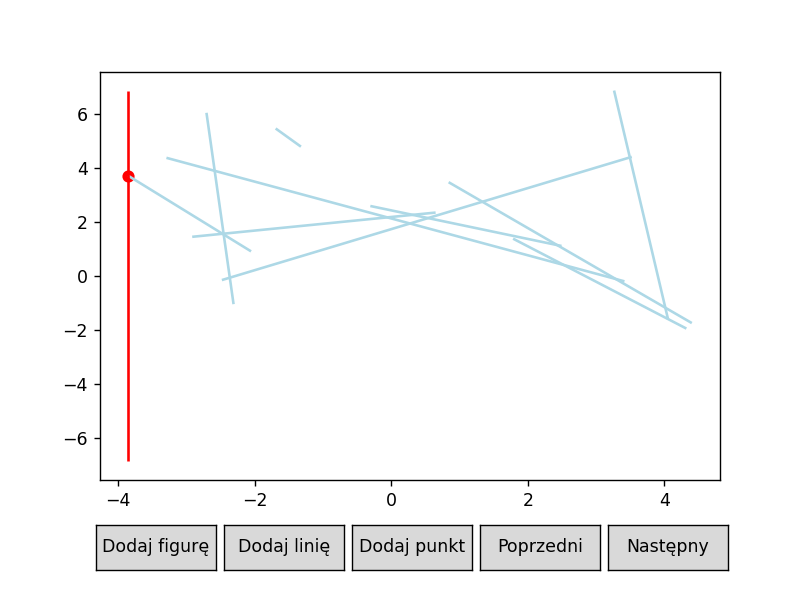

In [32]:
flag, scenes = any_intersections(l)

plot = Plot(scenes=scenes)
print(flag)
plot.draw()

16
3 8
0 2
0 8
0 3
2 3
0 1
1 2
3 9
1 9
1 6
6 9
2 5
2 6
1 4
4 6
4 5


<IPython.core.display.Javascript object>


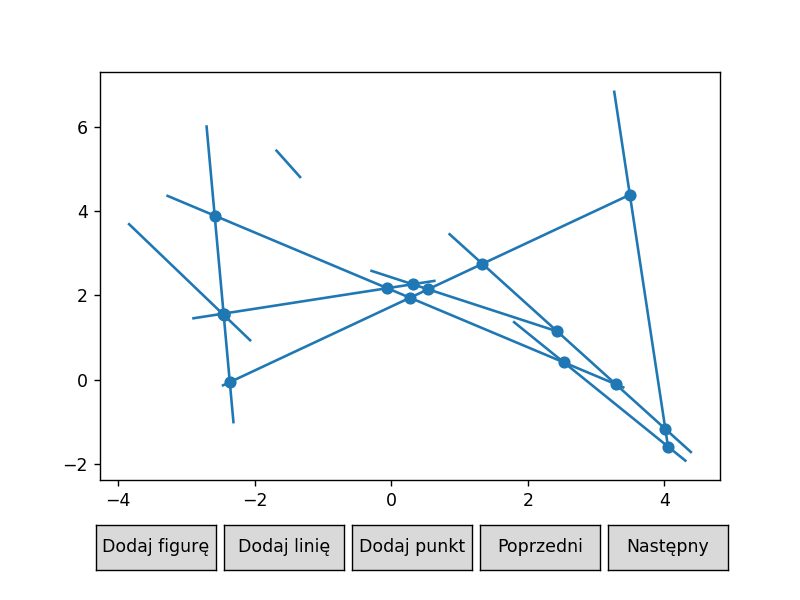

In [33]:
result, result_full, scenes = find_intersections(l)
plot = Plot(scenes=scenes)
print(len(result))
for point in result_full:
    print(point.s, point.t)
plot.draw()

In [34]:
result, result_full, scenes = find_intersections(lx)
plot = Plot(scenes=scenes)
print(len(result))
for point in result_full:
    print(point.s, point.t)
plot.draw()

NameError: name 'lx' is not defined